In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import healpy as hp
from scipy.stats import binned_statistic
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import time
import sys
import sqlite3
import json
import glob
from natsort import natsorted

In [2]:
# taken from Peter and Lynne's original notebooks
# https://github.com/rhiannonlynne/notebooks/blob/master/Template%20Generation.ipynb
# https://github.com/yoachim/22_Scratch/blob/main/template_metrics/template_stuff.ipynb

# get just the first year of observations

In [3]:
baseline_db = "baseline_v3.0_10yrs.db"
year1_fname = 'first_year_{}.db'.format(baseline_db.split(".db")[0])

# nside = 256
nside = 32

# save_dir = "remove_no_template_results_{}".format(nside)
save_dir = "remove_no_template_results_{}_noDD".format(nside)
# save_dir = "/Volumes/Nargothrond/rubin_templates/remove_no_template_results_{}_noDD".format(nside)

In [4]:
opsim_fname = year1_fname
opsim_fname

'first_year_baseline_v3.0_10yrs.db'

In [5]:
opsdb = maf.OpsimDatabase(opsim_fname)
runName = os.path.split(opsdb)[-1].replace('.db', '')
opsdb,runName

('first_year_baseline_v3.0_10yrs.db', 'first_year_baseline_v3.0_10yrs')

In [6]:
# range of nights to investigate (year 1 of survey)
night_min = 0
night_max = 365

# template generation timescales to test
tscales = [28,28*4,28*6]
# tscales = [1,3,7,14,28,28*4,28*6]
# tscales = [3,7,14,28,28*4,28*6]

# store the timescale and template generation nights in a dict
template_timescales = {}

for tscale in tscales:
    
    # divide year 1 into chunks of a given template_timescale
    template_nights = np.arange(0,night_max+tscale,tscale)
    template_nights[-1] = night_max # consider only the first year
        
    template_timescales[str(tscale)] = template_nights
    
template_timescales

{'28': array([  0,  28,  56,  84, 112, 140, 168, 196, 224, 252, 280, 308, 336,
        364, 365]),
 '112': array([  0, 112, 224, 336, 365]),
 '168': array([  0, 168, 336, 365])}

In [7]:
if not os.path.isfile(year1_fname): 
    print("get year 1 observations")
    conn = sqlite3.connect(baseline_db)
    df = pd.read_sql('select * from observations;', conn)
    df_year1 = df[df["night"]<night_max]
    conn.close()

    # open up a connection to a new database
    conn = sqlite3.connect(year1_fname)
    df_year1.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()
    
else:
    conn = sqlite3.connect(year1_fname)
    df_year1 = pd.read_sql('select * from observations;', conn)
    conn.close()

# Load the saved template metric data and combine the chunks

In [8]:
def load_template_metric(runName,
                         metric="doAllTemplateMetrics_Count",
                         slicer = "HEAL",
                         filt="all",save_dir="remove_no_template_results_32",
                         time = False,
                         operation="sum",
                        print_flag=False):
    
    """
    The doAllTemplateMetrics works by running metrics on batches of observations made between nights on which templates were generated.
    This function loads the all the files of a previously run metric.
    An operation can be performed on all of these reloaded metrics,
    e.g. the total number of visits from the "Count" metric can be found by using "sum".
    
    time allows you to select a single metric file for some time batch
    
    The save_dir is searched for files matching some pattern: runName, metric, filt, slicer
    """
        
    # glob all files in the save_dir
    files = glob.glob("{}/*npz".format(save_dir))
    
    # select the relevant metric files using the patterns
    if filt=="all": # select all filters
        _files = [x for x in files if (runName in x) 
                 & (metric in x)
                 & (slicer in x)
                 & ~(("_u_".format(filt) in x)
                 | ("_g_".format(filt) in x)
                 | ("_r_".format(filt) in x)
                 | ("_i_".format(filt) in x)
                 | ("_z_".format(filt) in x)
                 | ("_y_".format(filt) in x))
                 ]
    elif "_or_" in filt:
        _files = [x for x in files if (runName in x) 
                  & (metric in x) 
                  & (slicer in x)
                  & ("_{}_".format(filt) in x)
                  & ("_or_" in x)]
    else:
        _files = [x for x in files if (runName in x) 
                  & (metric in x) 
                  & (slicer in x)
                  & ("_{}_".format(filt) in x)
                  & ("_or_" not in x)]
            
    if time: # trim down based on a specific timestamp
        _files = [x for x in _files if ("_lt_{}_".format(str(time)) in x)]        
        
    _files = natsorted(_files) # ensure files are in numerical order (based on the template generation night considered)
    if print_flag:
        print(_files)
    print(len(_files))
    
    if len(_files)==0:
        # there are no files
        print("no files")
        return

    # load all these metric files
    metric_bundle = []
    for x in _files:
        metric_bundle.append(maf.MetricBundle.load(x))

    # retrieve data/mask for all the masked arrays
    # each value in data corresponds to the metric value for some slice point
    data = [mb.metricValues.data for mb in metric_bundle]
    mask = [mb.metricValues.mask for mb in metric_bundle]
    metric_data = np.ma.array(data, mask=mask)

    if operation == "min":
        # find the minimum of all constituent metrics
        metric_vals = metric_data.min(axis=0)
    elif operation == "sum":
        # find the sum of all constituent metrics
        ### Sum of just one file should produce just the file?
        metric_vals = metric_data.sum(axis=0)
    ### Add a new operation for DeltaNight and NTemplate
#     elif operation == "first":
#         # take the first not badval value
    else:
        # return the untouched multidimensional masked array if you want to look at it separately
        print("no operation performed")
        metric_vals = metric_data
    
    print(metric_vals,len(metric_vals))
    
    # replace the masked values with nan
    metric_vals.fill_value = np.nan
    
    return metric_vals

In [9]:
def skymap_plot_Night(metric_plot, title, 
                      template_nights,
                      _min=None, _max=None):

    #plot the skymap
    x = hp.mollview(metric_plot, title=title, 
                    min = _min, max=_max,
                    cbar = None)
    hp.graticule()

    # customise the colorbar
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    # cbar = fig.colorbar(image, ax=ax, orientation = "horizontal",aspect = 30, location = "bottom")
    cbar = fig.colorbar(image, ax=ax, orientation = "horizontal", shrink = 0.5, location = "bottom",
                       pad = 0.05)

#     # fix the ticks at 0 nights and at the end?
#     ticks = template_nights[:-1]
#     cbar.set_ticks(ticks)
#     cbar.set_ticklabels(ticks)
    
    # set vmin, vmax to get constant scale for comparision?

#     fname = "{}.png".format("".join(title.split(" ")))
#     plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")
    
    plt.show()

In [10]:
# load individual template dates
# count the number of unique visits with templates

In [11]:
def skymap_plot(metric_plot, title):

    #plot the skymap
    x = hp.mollview(metric_plot, title=title, 
                    cbar = None)
    hp.graticule()

    # customise the colorbar
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    # cbar = fig.colorbar(image, ax=ax, orientation = "horizontal",aspect = 30, location = "bottom")
    cbar = fig.colorbar(image, ax=ax, orientation = "horizontal", shrink = 0.5, location = "bottom",
                       pad = 0.05)

#     fname = "{}.png".format("".join(title.split(" ")))
#     plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

    plt.show()

In [12]:
def histogram_plot(metric_plot,bins="auto",title="hist_plot",pix_area=None):
    
    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    n,b,p = ax1.hist(metric_plot, bins = bins, histtype = "step")

    # ax1.axvline(np.median(data),c="C{}".format(i))

    # total area
    print(sum(n)*pix_area)

    
    ### CONVERT UNITS OR SCALE AXIS?
    if pix_area:
        # scale the y axis to get sky area
        y_vals = ax1.get_yticks()
        ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])
        ax1.set_ylabel("area (square degrees)")
    else:
        ax1.set_ylabel("number of healpixels")

    ax1.set_xlabel("metric number")

    plt.title("{} {}".format(_runName,m))

    plt.show()

In [13]:
# plot the results of the default baseline simulation

### TODO
# MAKE SURE AN OPERATION IS NOT PERFORMED HERE
# if len(_files)==1 return just the metric?
# Could be fine as the sum over a len 1 array is unchanged

# for m in ["CountMetric","PairMetric"]:
#     filt = "all"
#     pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

#     _runName = "{}_nside-{}".format(runName,nside).replace(".","_")
#     print(_runName,m,filt)
#     metric_plot = load_template_metric(_runName,
#                                        metric=m,
#                                        filt=filt, print_flag=True,
#                                       save_dir = save_dir)
#     print(metric_plot.shape)

#     title = "{} {}".format(_runName,m)
#     skymap_plot(metric_plot, title = title)
#     histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 CountMetric all
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 30.0 25.0 24.0] 12288
(12288,)


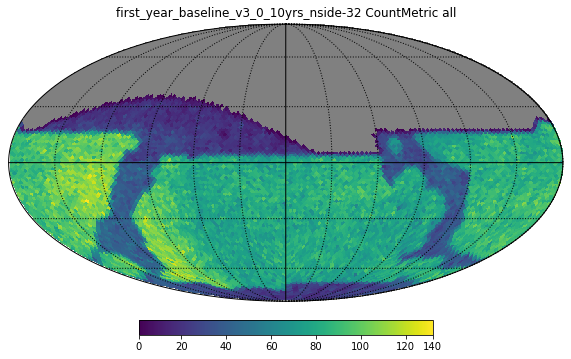

/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_59783/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


27998.836004244524


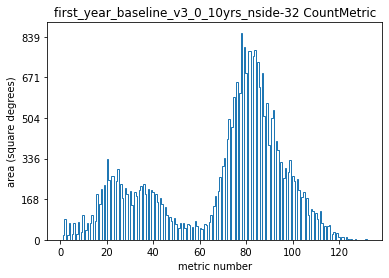

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 CountMetric u
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_u_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 4.0 2.0 1.0] 12288
(12288,)


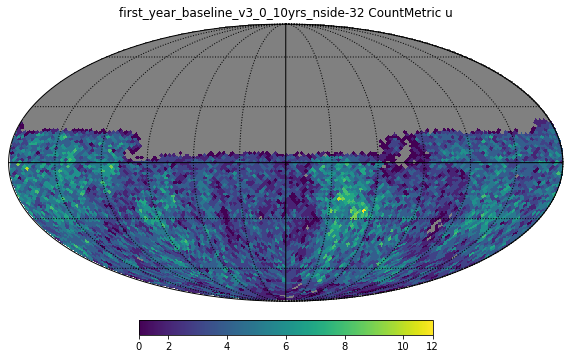

24446.945297710867


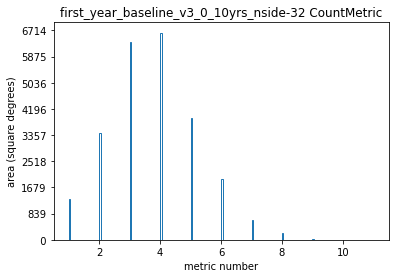

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 CountMetric g
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 3.0 2.0 2.0] 12288
(12288,)


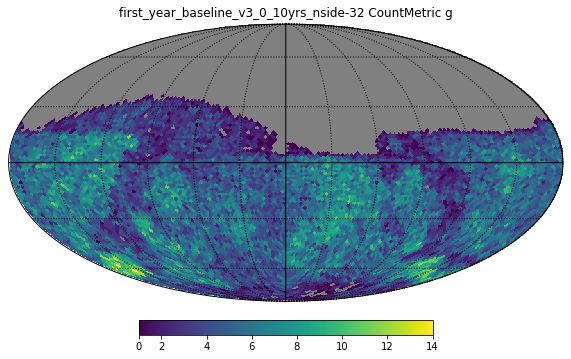

27485.18829337529


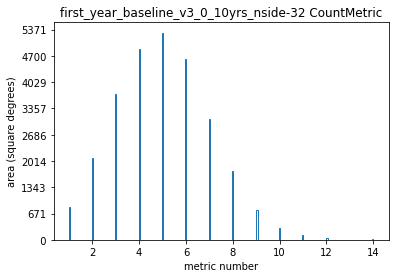

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 CountMetric r
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 4.0 4.0 5.0] 12288
(12288,)


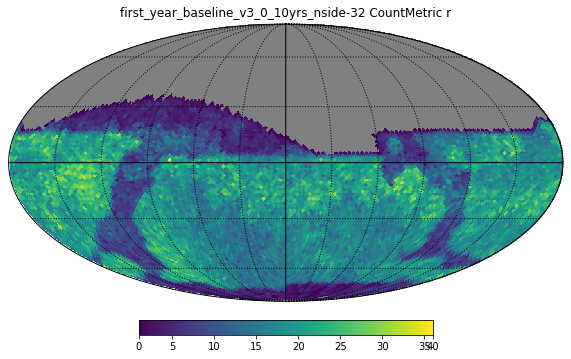

27888.04924307665


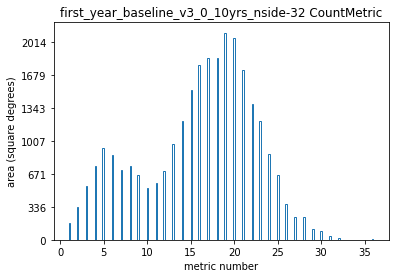

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 CountMetric i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_i_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 8.0 6.0 9.0] 12288
(12288,)


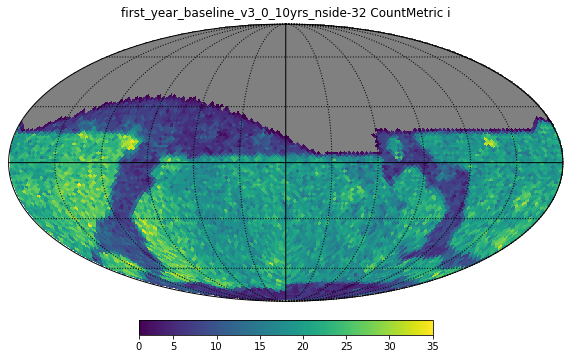

27958.54990927439


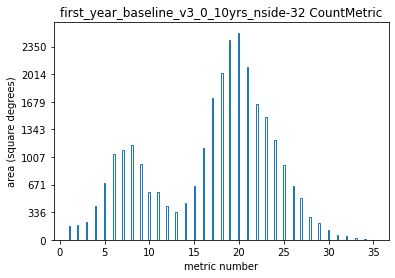

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 CountMetric z
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_z_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 5.0 5.0 4.0] 12288
(12288,)


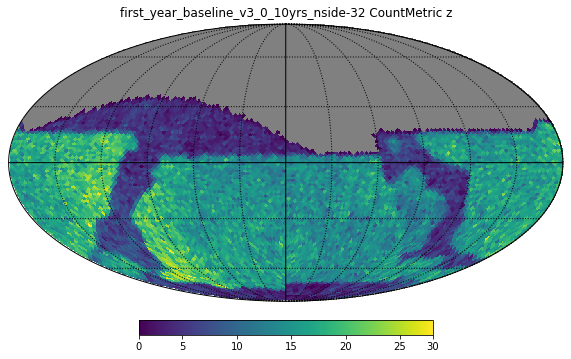

27867.906195591582


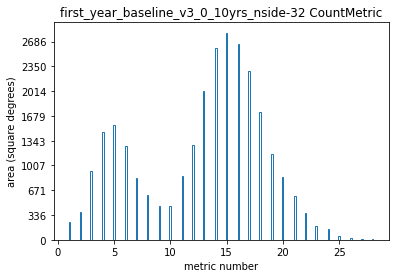

first_year_baseline_v3_0_10yrs_nside-32 CountMetric y
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_y_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 6.0 6.0 3.0] 12288
(12288,)


0.0 180.0 -180.0 180.0


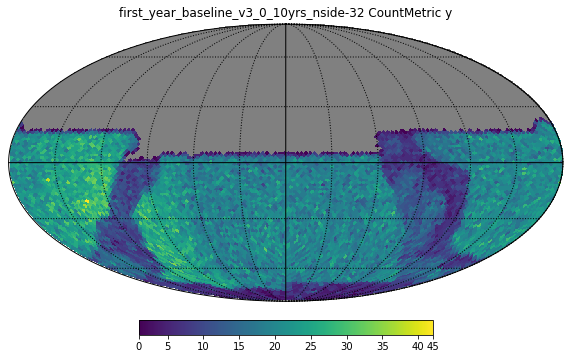

24900.163866124894


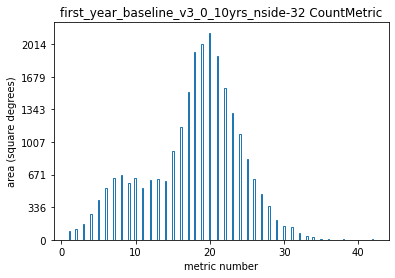

In [14]:
m = "CountMetric"

for filt in ["all","u","g","r","i","z","y"]:
    
    pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

    _runName = "{}_nside-{}".format(runName,nside).replace(".","_")
    print(_runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt, print_flag=True,
                                      save_dir = save_dir)
    print(metric_plot.shape)

    title = "{} {} {}".format(_runName,m,filt)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 PairMetric all
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 12.0 9.0 8.0] 12288
(12288,)


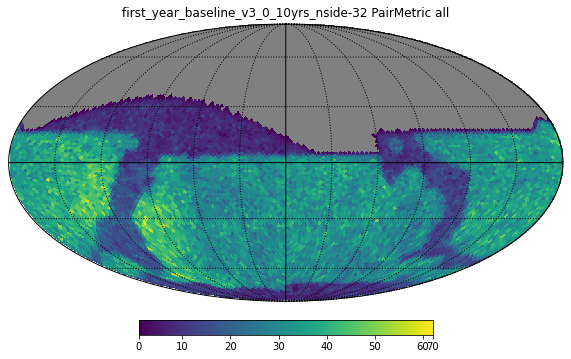

27961.907083855232


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_59783/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


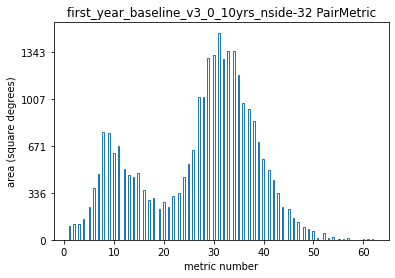

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 PairMetric r_or_g
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- 1.0] 12288
(12288,)


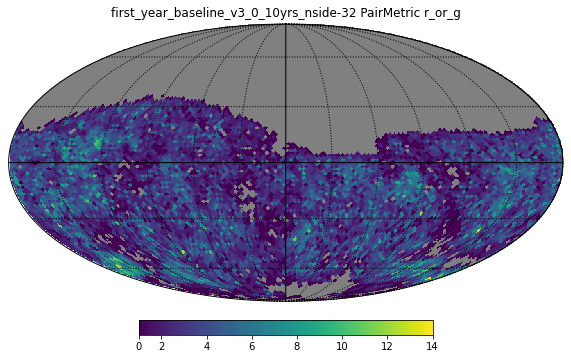

26320.24871382219


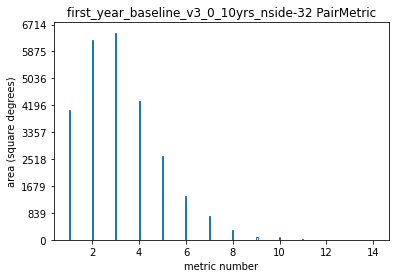

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 PairMetric r_or_i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_i_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 3.0 2.0 3.0] 12288
(12288,)


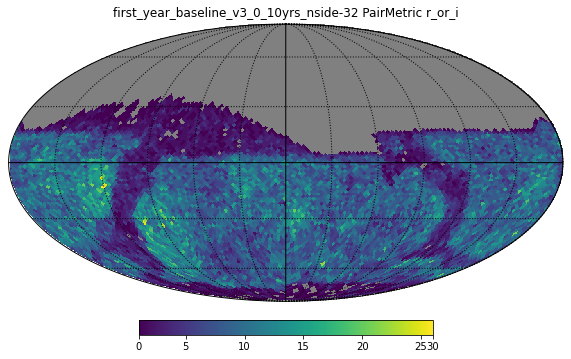

27461.688071309378


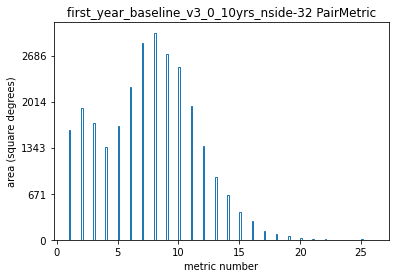

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 PairMetric r_or_z
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_z_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)


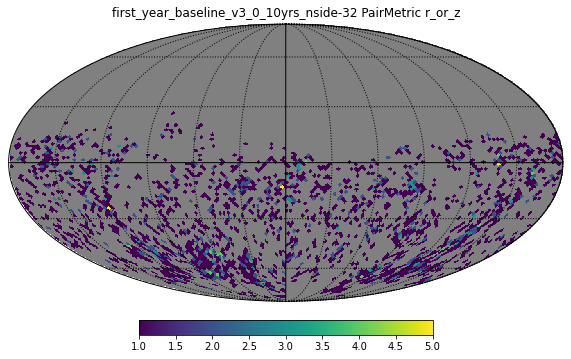

6791.564177048762


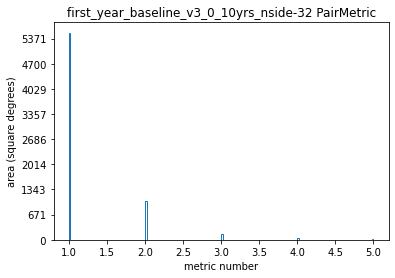

In [15]:
m = "PairMetric"

for filt in ["all","r_or_g","r_or_i","r_or_z"]:
    pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

    _runName = "{}_nside-{}".format(runName,nside).replace(".","_")
    print(_runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt, print_flag=True,
                                      save_dir = save_dir)
    print(metric_plot.shape)

    title = "{} {} {}".format(_runName,m,filt)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)

In [16]:
### TODO
# double check the area in the pair histogram

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight r
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


0.0 180.0 -180.0 180.0


Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 70.0 182.0 187.0] 12288
(12288,)


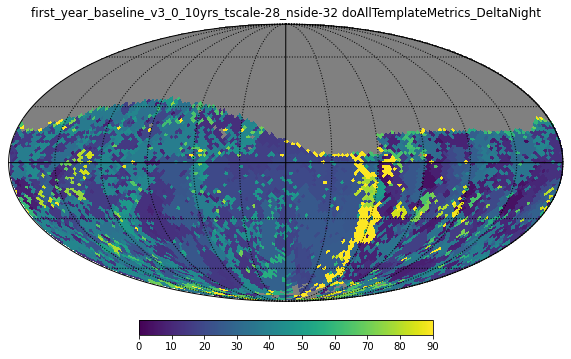

/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_59783/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


27367.687183045728


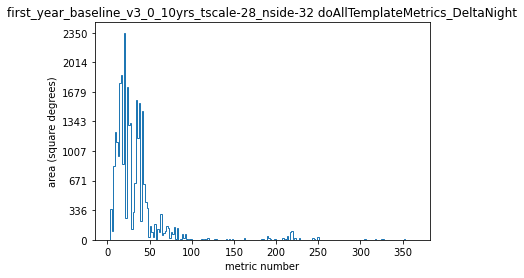

0.0 180.0 -180.0 180.0


first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight r
4
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 154.0 266.0 215.0] 12288
(12288,)


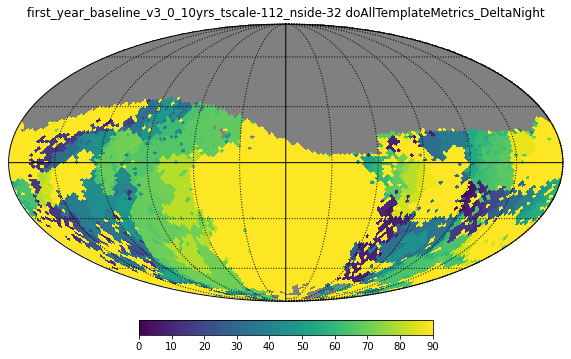

27350.901310141504


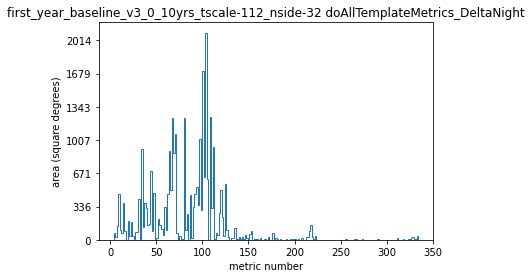

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight r
3
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 98.0 266.0 327.0] 12288
(12288,)


0.0 180.0 -180.0 180.0


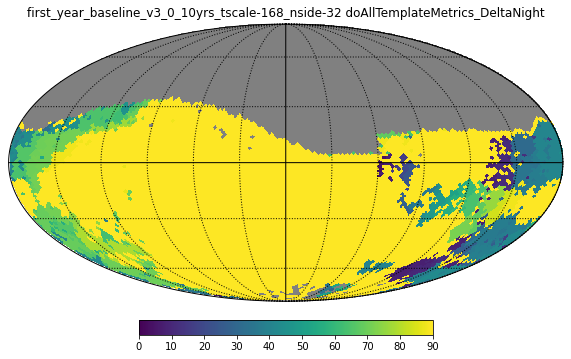

27350.901310141504


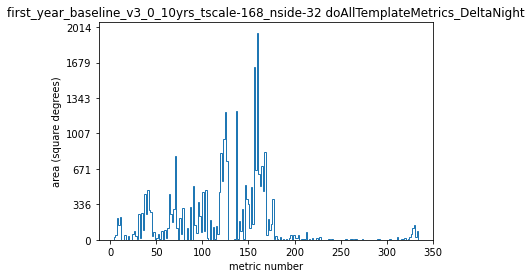

In [17]:
# m = "doAllTemplateMetrics_Night"
m = "doAllTemplateMetrics_DeltaNight" # add a vline at the template timescale to see if it peaks
filt = "r"

for tscale in tscales:
    
    # divide year 1 into chunks of a given template_timescale
    template_nights = np.arange(0,365+tscale,tscale)
    template_nights[-1] = 365 # consider only the first year
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,
                                       operation="min",save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {}".format(_runName,m)
    
#     skymap_plot_Night(metric_plot, title = title, template_nights = template_nights,
#                       _min = 0, _max = 365)
    skymap_plot_Night(metric_plot, title = title, template_nights = template_nights,
                      _min = 0, _max = 90)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)
    
#     break

In [18]:
metric_plot

masked_array(data=[--, --, --, ..., 98.0, 266.0, 327.0],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=nan)

first_year_baseline_v3.0_10yrs doPairTemplateMetrics_Pairs all
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


0.0 180.0 -180.0 180.0


Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 3.0 -- --] 12288
(12288,)


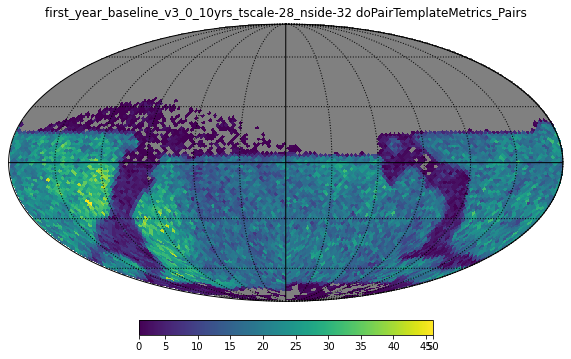

/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_59783/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


25870.387319989004


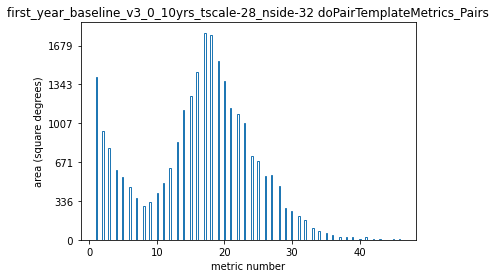

0.0 180.0 -180.0 180.0


first_year_baseline_v3.0_10yrs doPairTemplateMetrics_Pairs all
4
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 1.0 -- --] 12288
(12288,)


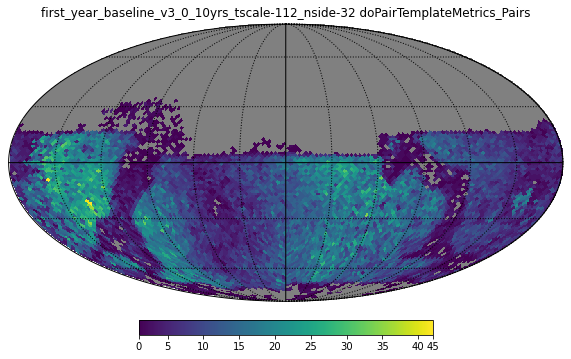

24554.374884297897


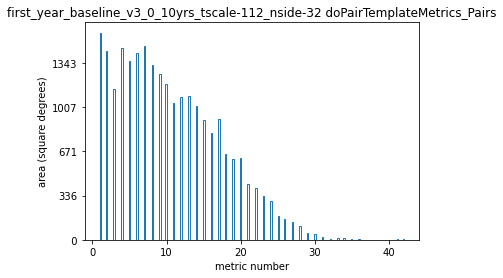

0.0 180.0 -180.0 180.0


first_year_baseline_v3.0_10yrs doPairTemplateMetrics_Pairs all
3
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 2.0 -- --] 12288
(12288,)


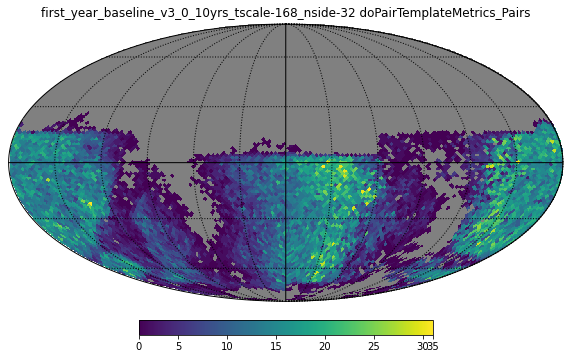

21724.276712645842


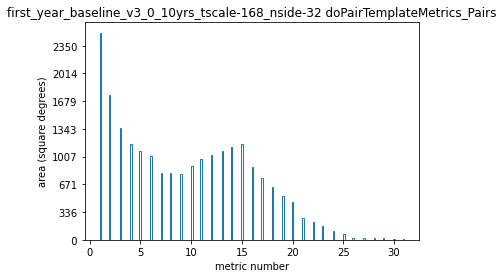

In [19]:
m = "doPairTemplateMetrics_Pairs"
filt = "all"
# filt = "r_or_g"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

for tscale in tscales:
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {}".format(_runName,m)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins=200,title=title,pix_area=pix_area)
        
#     break

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count all
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NS

0.0 180.0 -180.0 180.0


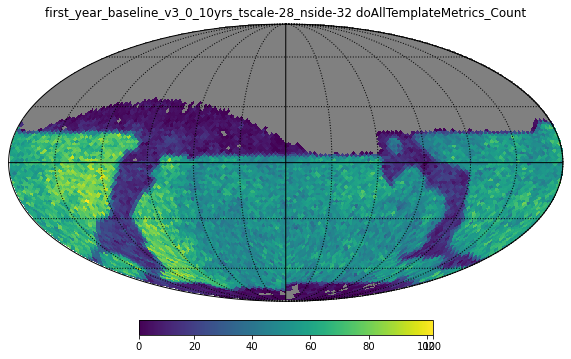

/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_59783/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


27371.04435762657


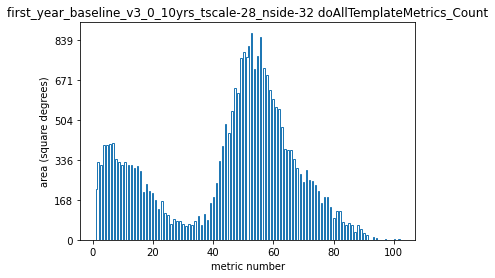

0.0 180.0 -180.0 180.0


first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count all
4
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 6.0 -- 3.0] 12288
(12288,)


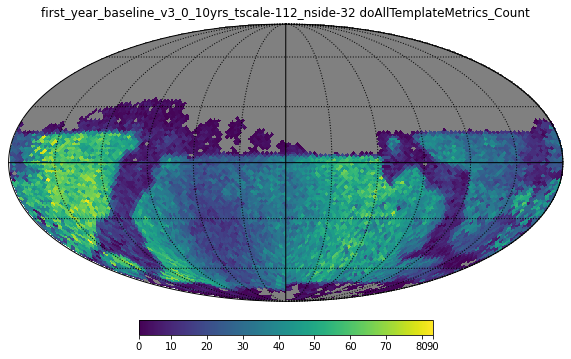

26407.53525292415


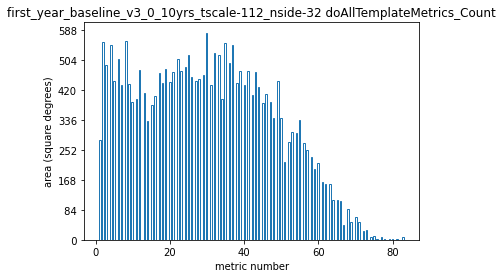

0.0 180.0 -180.0 180.0


first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count all
3
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 5.0 2.0 3.0] 12288
(12288,)


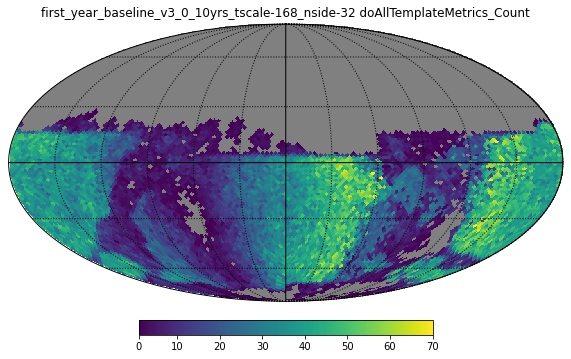

24974.021706903477


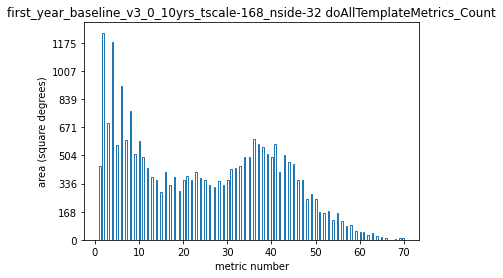

In [20]:
m = "doAllTemplateMetrics_Count"
filt = "all"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

for tscale in tscales:
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {}".format(_runName,m)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)
        
#     break

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count u
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


0.0 180.0 -180.0 180.0


Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 1.0 -- --] 12288
(12288,)


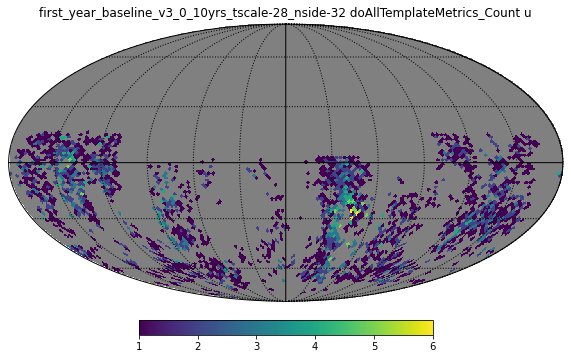

6888.922239893257


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_59783/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


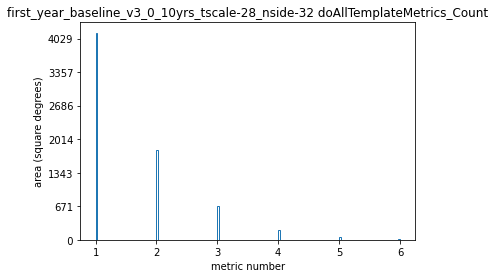

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count g
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSID

0.0 180.0 -180.0 180.0


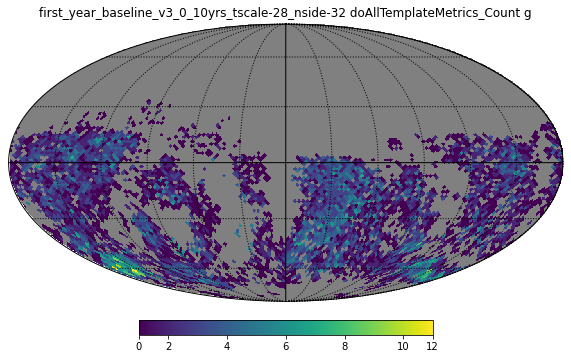

15107.285613801003


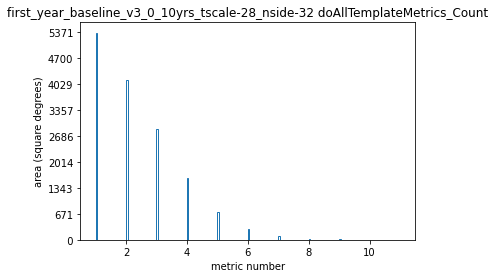

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count r
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSID

0.0 180.0 -180.0 180.0


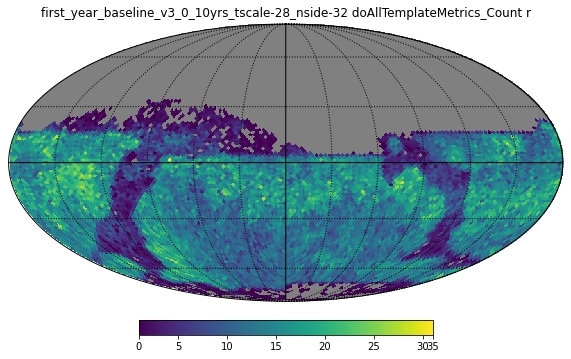

26249.748047624453


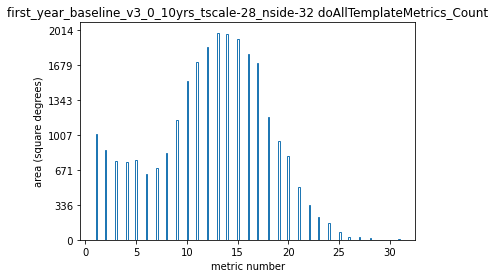

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count i
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSID

0.0 180.0 -180.0 180.0


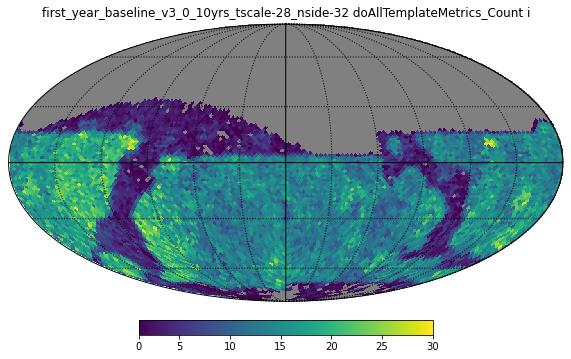

27028.612550380414


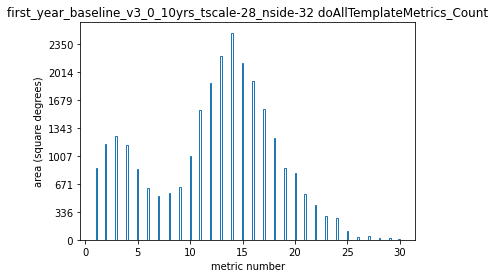

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count z
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSID

0.0 180.0 -180.0 180.0


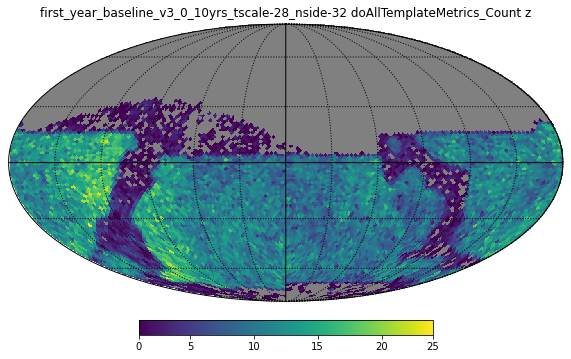

25450.74049738342


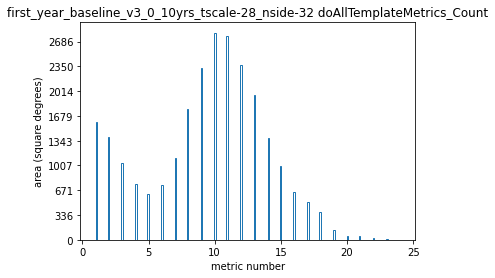

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count y
14
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSID

0.0 180.0 -180.0 180.0


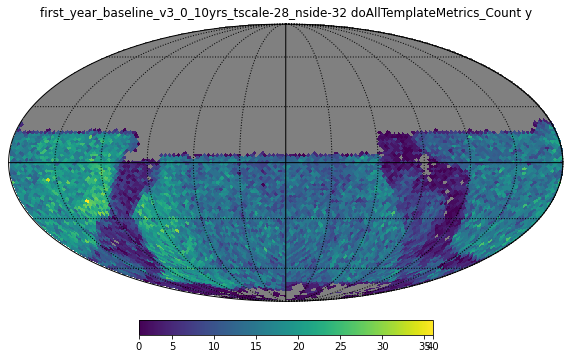

24070.941744656262


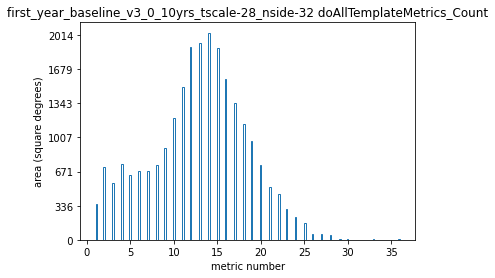

In [21]:
m = "doAllTemplateMetrics_Count"
filters = ["u","g","r","i","z","y"]
tscale = 28
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

for filt in filters:
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {} {}".format(_runName,m, filt)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)
        

In [22]:
# Count up area in footprint from the baseline, for reference (varies by filter)
m = "CountMetric"
_runName = "{}_nside-{}".format(runName,nside).replace(".","_")
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

footprint_area = {}
for filt in 'ugrizy':
    
    print(_runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt, print_flag=True,
                                      save_dir = save_dir)
    print(metric_plot.shape)
    
    x = metric_plot.data
    
    footprint_area[filt] = len(x[x>0]) * pix_area    

first_year_baseline_v3_0_10yrs_nside-32 CountMetric u
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_u_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 4.0 2.0 1.0] 12288
(12288,)
first_year_baseline_v3_0_10yrs_nside-32 CountMetric g
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 3.0 2.0 2.0] 12288
(12288,)
first_year_baseline_v3_0_10yrs_nside-32 CountMetric r
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 4.0 4.0 5.0] 12288
(12288,)
first_year_baseline_v3_0_10yrs_nside-32 CountMetric i
['re

In [23]:
footprint_area

{'u': 24446.945297710867,
 'g': 27485.18829337529,
 'r': 27888.04924307665,
 'i': 27958.54990927439,
 'z': 27867.906195591582,
 'y': 24900.163866124894}

In [24]:
m = "doAllTemplateMetrics_Count"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

area_Count = {}

for tscale in tscales:
    
    template_nights = template_timescales[str(tscale)]
    print(template_nights)
    
    area_Count[str(tscale)] = {}
    
    for filt in 'ugrizy':
#     for filt in 'grizy':
        
        visit_area = []

        for t in template_nights[1:]:
        
            _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
            print(runName,m,filt, t)
            metric_plot = load_template_metric(_runName,
                                               metric=m,
                                               filt=filt,
                                               time = t,
                                               save_dir = save_dir,
                                              print_flag = True)
            
            # there may be missing metric files (e.g. no observations of u with t<7d)
            if metric_plot is None:
                visit_area.append(0)
                continue
                
            print(metric_plot.shape)
            
            x = metric_plot.data
            area = len(x[x>0]) * pix_area
            
            visit_area.append(area)
            print(area)    
            
        visit_area = np.array(visit_area)
        
        area_Count[str(tscale)][filt] = visit_area
#         break


[  0  28  56  84 112 140 168 196 224 252 280 308 336 364 365]
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count u 28
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_u_and_night_lt_28_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
0.0
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count u 56
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_u_and_night_lt_56_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
43.643269550980676
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count u 84
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_u_and_night_lt_84_and_note_not_like_DD_HEAL.npz']


['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_g_and_night_lt_280_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
1655.0870683564208
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count g 308
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_g_and_night_lt_308_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
1258.9404678167502
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count g 336
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_g_and_night_lt_336_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 122

['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_i_and_night_lt_168_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 1.0 1.0 --] 12288
(12288,)
9930.522410138525
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count i 196
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_i_and_night_lt_196_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 1.0 2.0 3.0] 12288
(12288,)
10964.532181038683
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count i 224
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_i_and_night_lt_224_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --]

['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_y_and_night_lt_84_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
7906.146137889191
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count y 112
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_y_and_night_lt_112_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
6338.345608634731
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count y 140
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_y_and_night_lt_140_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288


['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Count_i_and_night_lt_224_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 3.0 -- 3.0] 12288
(12288,)
12381.259854155132
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count i 336
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Count_i_and_night_lt_336_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
16268.868018773257
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count i 365
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Count_i_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --

['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Count_z_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
10225.953773252857
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count y 168
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Count_y_and_night_lt_168_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
0.0
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count y 336
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Count_y_and_night_lt_336_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 3.0 -- --] 12288
(12288,)

In [25]:
### u filter failing for 7d timescale? Missing a file?
# There are no u observations with t<7d
### Add a missing metric file exception

28 u 0.30760780005492994
28 g 0.7615732258458533
28 r 4.0038521728662575
28 i 4.232829010566763
28 z 3.6843753764606673
28 y 4.136712956721046


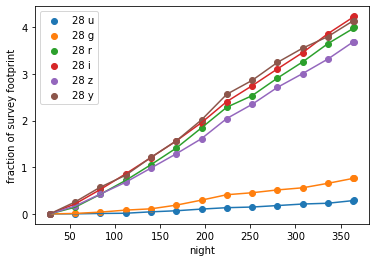

In [26]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])


for tscale in [28]:
    
    template_nights = template_timescales[str(tscale)]
        
    for filt in 'ugrizy':
#     for filt in 'grizy':
        
        visit_area = area_Count[str(tscale)][filt]
        
        cum_visit_area = visit_area.cumsum()
        
        ax1.plot(template_nights[1:],cum_visit_area/footprint_area[filt])
        ax1.scatter(template_nights[1:],cum_visit_area/footprint_area[filt],label = "{} {}".format(tscale,filt))
        
        print(tscale,filt,cum_visit_area[-1]/footprint_area[filt])

ax1.set_xlabel("night")
ax1.set_ylabel("fraction of survey footprint")

ax1.legend()

plt.show()

In [27]:
m = "doAllTemplateMetrics_DeltaNight"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

area_DeltaNight = {}

for tscale in tscales:
    
    template_nights = template_timescales[str(tscale)]
    print(template_nights)
    
    area_DeltaNight[str(tscale)] = {}
    
    for filt in 'ugrizy':
        
        visit_area = []

        for t in template_nights[1:]:
        
            _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
            print(runName,m,filt, t)
            metric_plot = load_template_metric(_runName,
                                               metric=m,
                                               filt=filt,
                                               time = t,
                                               save_dir = save_dir,
                                              print_flag = True)
            
            if metric_plot is None:
                visit_area.append(0)
                continue
                
            print(metric_plot.shape)
            
            x = metric_plot.data
            area = len(x[x>0]) * pix_area
            
            visit_area.append(area)
            print(area)    
            
        visit_area = np.array(visit_area)
        
        area_DeltaNight[str(tscale)][filt] = visit_area
#         break

### This is probably not correct...
# instead just load DeltaNight for all year 1 with minimum operation
# i.e. convert year 1 DeltaNight histogram to a cumulative dist


[  0  28  56  84 112 140 168 196 224 252 280 308 336 364 365]
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight u 28
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_u_and_night_lt_28_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
0.0
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight u 56
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_u_and_night_lt_56_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
1265.6548169784396
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight u 84
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_u_and_night_lt_84_an

['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_g_and_night_lt_252_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 65.0 -- --] 12288
(12288,)
18887.464191832096
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight g 280
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_g_and_night_lt_280_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 93.0 -- --] 12288
(12288,)
19669.685869168905
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight g 308
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_g_and_night_lt_308_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminute

['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_i_and_night_lt_84_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- 55.0] 12288
(12288,)
11562.109256429034
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight i 112
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_i_and_night_lt_112_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 56.0 -- 83.0] 12288
(12288,)
15003.213201794817
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight i 140
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_i_and_night_lt_140_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminut

[-- -- -- ... 307.0 307.0 307.0] 12288
(12288,)
26988.32645541028
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight z 364
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_z_and_night_lt_364_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 335.0 335.0 335.0] 12288
(12288,)
27152.828009871668
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight z 365
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_z_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 363.0 363.0 363.0] 12288
(12288,)
27250.186072716162
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight y 28
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTempla

['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_DeltaNight_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 177.0 -- --] 12288
(12288,)
24265.657870345254
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight r 112
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_DeltaNight_r_and_night_lt_112_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
0.0
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight r 224
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_DeltaNight_r_and_night_lt_224_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- .

['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_DeltaNight_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... 177.0 -- --] 12288
(12288,)
24265.657870345254
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight r 168
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_DeltaNight_r_and_night_lt_168_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- ... -- -- --] 12288
(12288,)
0.0
first_year_baseline_v3.0_10yrs doAllTemplateMetrics_DeltaNight r 336
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_DeltaNight_r_and_night_lt_336_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- .

In [28]:
area_DeltaNight["28"]

{'u': array([    0.        ,  1265.65481698,  2249.30696917,  3833.89337132,
         5502.409138  ,  7647.64369516,  9165.08660571, 11035.03284724,
        13150.05283317, 14439.20787221, 15808.9351012 , 17175.3051556 ,
        18011.24162623, 19632.75694878]),
 'g': array([    0.        ,  1527.51443428,  3783.53575261,  7100.42423849,
         9819.73564897, 12297.33048963, 14761.49663197, 17027.58947404,
        18887.46419183, 19669.68586917, 21267.70096965, 23141.00438576,
        24265.65787035, 24567.80358262]),
 'r': array([    0.        ,  6308.13103741, 11095.46198969, 14590.28072835,
        17521.09413743, 20519.05103812, 22660.9284207 , 24561.08923346,
        26276.60544427, 26880.89686882, 27119.25626406, 27236.75737439,
        27350.90131014, 27367.68718305]),
 'i': array([    0.        ,  7909.50331247, 11562.10925643, 15003.21320179,
        17843.38289719, 20163.19053255, 22284.92486765, 24168.2998075 ,
        26864.11099592, 27203.18562858, 27485.18829338, 27528.

In [29]:
template_nights, len(template_nights)

(array([  0, 168, 336, 365]), 4)

In [30]:
visit_area, len(visit_area)

(array([    0.        , 20250.47707166, 24688.66186753]), 3)

In [31]:
visit_area.cumsum(), len(visit_area.cumsum())

(array([    0.        , 20250.47707166, 44939.13893919]), 3)

28 u 0.8030760780005493
28 g 0.8938561133504336
28 r 0.9813410376790659
28 i 0.9872718539865513
28 z 0.9778339959041079
28 y 0.9920453013347715


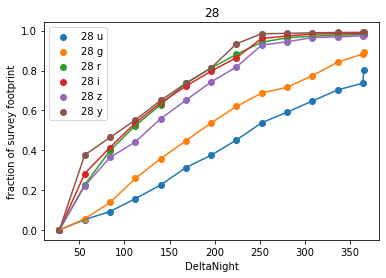

112 u 0.7367481461137051
112 g 0.8828630756076707
112 r 0.9807391356687132
112 i 0.9865513928914504
112 z 0.9743404409107337
112 y 0.9915059997303493


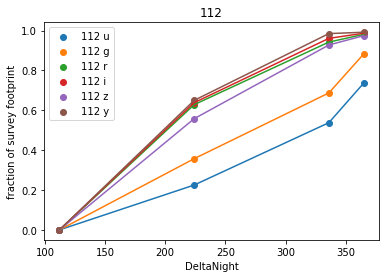

168 u 0.7367481461137051
168 g 0.8828630756076707
168 r 0.9807391356687132
168 i 0.9865513928914504
168 z 0.9743404409107337
168 y 0.9915059997303493


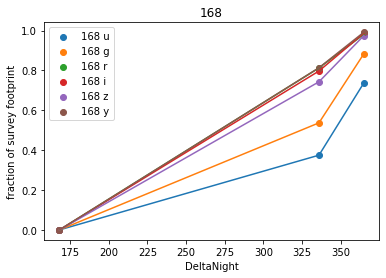

In [32]:
for tscale in tscales:

    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    template_nights = template_timescales[str(tscale)]

    for filt in 'ugrizy':

        visit_area = area_DeltaNight[str(tscale)][filt]

        ax1.plot(template_nights[1:],visit_area/footprint_area[filt])
        ax1.scatter(template_nights[1:],visit_area/footprint_area[filt],label = "{} {}".format(tscale,filt))

        print(tscale,filt,visit_area[-1]/footprint_area[filt])

    ax1.set_xlabel("DeltaNight")
    ax1.set_ylabel("fraction of survey footprint")

    ax1.legend()
    plt.title(tscale)

    plt.show()

In [33]:
# the stepped pattern emerges as a result of the template cadence and general survey cadence
# What is the typical revisit timescale of the baseline?
# note that the 28 d timescale, u filter last jump up is due to a very short last time period to get up to 365 d

In [34]:
### need a "first" operation when loading
### check these plots, why does Count need to be cumulative but DeltaNight is regular?
### Why does our z differ so much to Lynne's?

28 u 0.8030760780005493
112 u 0.7367481461137051
168 u 0.7367481461137051


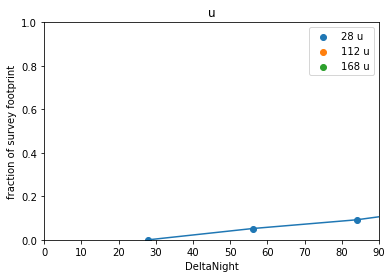

28 g 0.8938561133504336
112 g 0.8828630756076707
168 g 0.8828630756076707


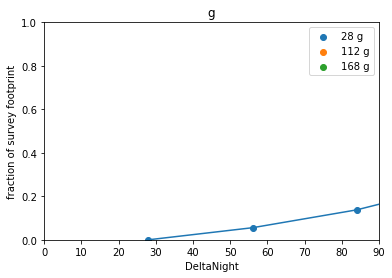

28 r 0.9813410376790659
112 r 0.9807391356687132
168 r 0.9807391356687132


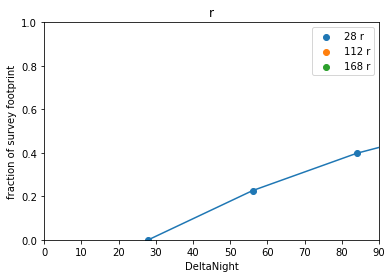

28 i 0.9872718539865513
112 i 0.9865513928914504
168 i 0.9865513928914504


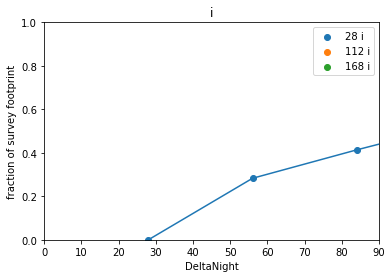

28 z 0.9778339959041079
112 z 0.9743404409107337
168 z 0.9743404409107337


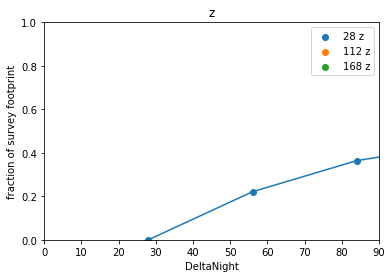

28 y 0.9920453013347715
112 y 0.9915059997303493
168 y 0.9915059997303493


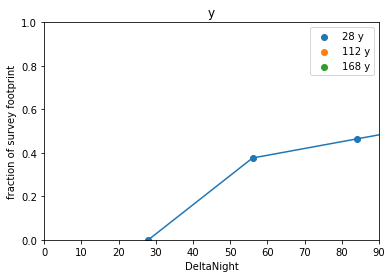

In [35]:
for filt in "ugrizy":
    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    for tscale in tscales:

        template_nights = template_timescales[str(tscale)]

        visit_area = area_DeltaNight[str(tscale)][filt]

        ax1.plot(template_nights[1:],visit_area/footprint_area[filt])
        ax1.scatter(template_nights[1:],visit_area/footprint_area[filt],label = "{} {}".format(tscale,filt))

        print(tscale,filt,visit_area[-1]/footprint_area[filt])

    ax1.set_xlabel("DeltaNight")
    ax1.set_ylabel("fraction of survey footprint")

    ax1.legend()
    
    plt.title(filt)
    
    ax1.set_ylim(0,1)
    ax1.set_xlim(0,90)

    plt.show()

In [36]:
filt = "u"
tscale = 28
visit_area = area_DeltaNight[str(tscale)][filt]
visit_area/footprint_area[filt]

array([0.        , 0.05177149, 0.09200769, 0.15682505, 0.22507553,
       0.31282615, 0.37489701, 0.45138698, 0.53790168, 0.59063444,
       0.646663  , 0.70255424, 0.73674815, 0.80307608])